# Laporan Proyek Sistem Rekomendasi Buku - Natalio Tumuahi


Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

## **Data Loading**

In [2]:
user = pd.read_csv('https://raw.githubusercontent.com/natalio123/rekomendasi_buku/master/dataset/Users.csv', delimiter=';')
book = pd.read_csv('https://raw.githubusercontent.com/natalio123/rekomendasi_buku/master/dataset/Books.csv', delimiter=';')
rating = pd.read_csv('https://raw.githubusercontent.com/natalio123/rekomendasi_buku/master/dataset/Ratings.csv', delimiter=';')

<ipython-input-2-202c07c16baf>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  user = pd.read_csv('https://raw.githubusercontent.com/natalio123/rekomendasi_buku/master/dataset/Users.csv', delimiter=';')


In [3]:
print('Jumlah data users: ', len(user))
print('Jumlah data books: ', len(book))
print('Jumlah data ratings: ', len(rating))

Jumlah data users:  278859
Jumlah data books:  271379
Jumlah data ratings:  1149780


## **Data Understanding**


In [4]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278859 entries, 0 to 278858
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278859 non-null  object
 1   Age      168627 non-null  object
dtypes: object(2)
memory usage: 4.3+ MB


In [5]:
# cek duplikate dari file users.csv
duplikat1= user.duplicated().sum()
duplikat1

np.int64(0)

In [6]:
# cek missing value
missing_value_user = user.isnull().mean() * 100
missing_value_user

,0
User-ID,0.000000
Age,39.529655


<Axes: xlabel='Age'>

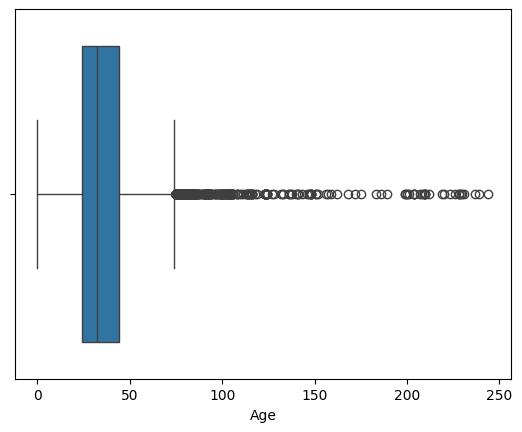

In [7]:
# Konversi dan drop sementara NaN hanya untuk keperluan visualisasi outlier
user['Age'] = pd.to_numeric(user['Age'], errors='coerce')
sns.boxplot(x=user['Age'].dropna())

Insight: <br>
Berdasarkan analisis boxplot pada fitur Age, didapatkan bahwa data usia pengguna tersebar antara sekitar 5 hingga 60 tahun, dengan median usia berada di sekitar 35 tahun. Namun, terdapat banyak outlier signifikan di atas 80 tahun, bahkan hingga mendekati 250 tahun, yang menunjukkan adanya nilai-nilai anomali atau kesalahan input data. Hal ini menandakan perlunya pembersihan data untuk memastikan analisis dan model yang lebih akurat.

In [9]:
user.describe(include='all')

,User-ID,Age
count,278859,167151.000000
unique,278859,NaN
top,278858,NaN
freq,1,NaN
mean,NaN,34.728407
std,NaN,14.408645
min,NaN,0.000000
25%,NaN,24.000000
50%,NaN,32.000000
75%,NaN,44.000000


In [10]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISBN       271379 non-null  object
 1   Title      271379 non-null  object
 2   Author     271377 non-null  object
 3   Year       271379 non-null  int64 
 4   Publisher  271377 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB


In [11]:
# cek duplikat dari dataset books
book.duplicated().sum()

np.int64(1)

In [12]:
# cek missing value
book.isnull().mean() * 100

,0
ISBN,0.000000
Title,0.000000
Author,0.000737
Year,0.000000
Publisher,0.000737


<Axes: xlabel='Year'>

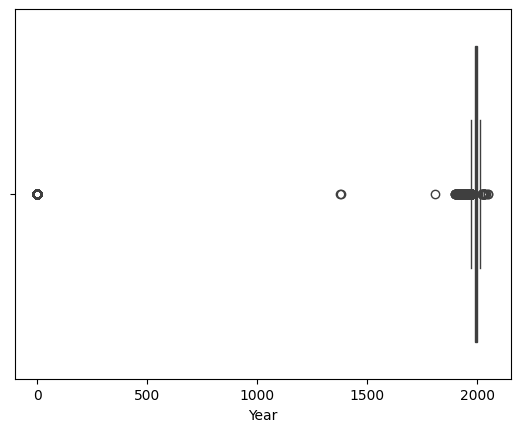

In [13]:
# cek outliers
sns.boxplot(x=book['Year'])

Insight: <br>
Berdasarkan analisis boxplot pada fitur Year, dapat dilihat bahwa sebagian besar data tahun terdistribusi secara normal di sekitar tahun 1900 hingga 2020. Namun, terdapat beberapa outlier ekstrem yang mencurigakan, seperti tahun 0, 1000, 1400, dan 1700, yang secara realistis tidak mungkin merepresentasikan tahun terbit buku modern. Kehadiran nilai-nilai tersebut menunjukkan adanya kesalahan entri data atau nilai yang hilang yang digantikan dengan default, sehingga perlu dilakukan pembersihan atau imputasi data agar analisis menjadi valid.


In [14]:
book.describe(include='all')

,ISBN,Title,Author,Year,Publisher
count,271379,271379,271377,271379.000000,271377
unique,271378,242154,102029,NaN,16910
top,0486404242,Selected Poems,Agatha Christie,NaN,Harlequin
freq,2,27,632,NaN,7536
mean,NaN,NaN,NaN,1959.756050,NaN
std,NaN,NaN,NaN,258.011363,NaN
min,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,1989.000000,NaN
50%,NaN,NaN,NaN,1995.000000,NaN
75%,NaN,NaN,NaN,2000.000000,NaN


In [15]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   User-ID  1149780 non-null  int64 
 1   ISBN     1149780 non-null  object
 2   Rating   1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [16]:
# cek duplikat
rating.duplicated().sum()

np.int64(0)

In [17]:
# cek missing value
rating.isnull().mean() * 100

,0
User-ID,0.0
ISBN,0.0
Rating,0.0


In [18]:
rating.describe(include='all')

,User-ID,ISBN,Rating
count,1.149780e+06,1149780,1.149780e+06
unique,NaN,340556,NaN
top,NaN,0971880107,NaN
freq,NaN,2502,NaN
mean,1.403864e+05,NaN,2.866950e+00
std,8.056228e+04,NaN,3.854184e+00
min,2.000000e+00,NaN,0.000000e+00
25%,7.034500e+04,NaN,0.000000e+00
50%,1.410100e+05,NaN,0.000000e+00
75%,2.110280e+05,NaN,7.000000e+00


In [19]:
# ubah tipe data User-ID menjadi string
rating['User-ID'] = rating['User-ID'].astype(str)
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   User-ID  1149780 non-null  object
 1   ISBN     1149780 non-null  object
 2   Rating   1149780 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 26.3+ MB


<Axes: xlabel='Rating'>

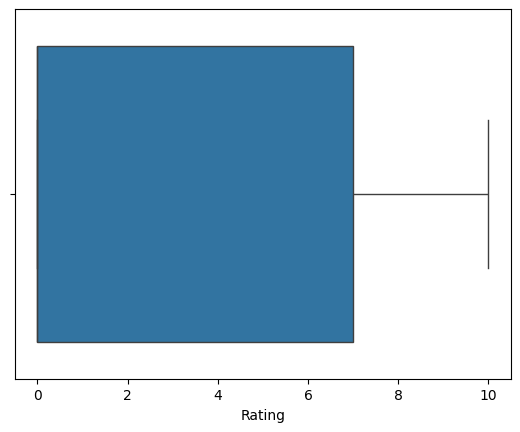

In [20]:
# cek outliers
sns.boxplot(x=rating['Rating'])

Insight: <br>
Berdasarkan analisis boxplot pada fitur Rating, dapat disimpulkan bahwa data rating tersebar merata dari nilai 0 hingga 10, tanpa adanya outlier yang mencolok. Median berada di sekitar nilai 5, menunjukkan bahwa sebagian besar pengguna memberikan rating pada tingkat yang moderat atau netral. Penyebaran yang luas ini mengindikasikan adanya variabilitas penilaian yang tinggi, mencerminkan perbedaan preferensi dan pendapat pengguna terhadap buku yang dinilai.

## **Data Preprocessing**


In [21]:
# Hapus outlier variabel user
df_numeric = user['Age']
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
df = user[~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR)))]

# cek ukuran dataset
user.shape

(278859, 2)

In [22]:
# Hapus duplikat variabel book
book = book.drop_duplicates()
book.shape

(271378, 5)

In [23]:
# Isi missing value dengan median
user['Age'].fillna(user['Age'].median(), inplace=True)

# Ubah tipe data menjadi integer
user['Age'] = user['Age'].astype(int)

# Filter data dengan usia yang masuk akal (antara 5 sampai 80 tahun)
user = user[(user['Age'] >= 5) & (user['Age'] <= 80)]

In [24]:
# Hapus outlier variabel book
df_numeric = book['Year']
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
df = book[~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR)))]

# cek ukuran dataset
book.shape

(271378, 5)

In [25]:
# Hapus missing value pada variabel book
book.dropna(inplace=True)
book.shape

<ipython-input-25-82386fb09e34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book.dropna(inplace=True)


(271374, 5)

In [26]:
# hapus rating 0
rating= rating[rating['Rating'] > 0]
rating.shape

(433671, 3)

In [27]:
# Fungsi untuk memisahkan inisial penulis yang digabung menjadi satu kata
def process_author_name(author_name):
  author_name = re.sub(r'(\w)\.(\s?)(\w)', r'\1 \3', author_name)
  author_name = re.sub(r'(\w)\.(\s?)(\w)', r'\1 \3', author_name)  # Memastikan titik dihapus antara setiap inisial

  # Menghapus titik di akhir nama setelah inisial (contoh: "Mark P. O.")
  author_name = re.sub(r'(\w)\.(\s?)(\w)', r'\1 \2', author_name)  # Mengubah "P." menjadi "P"

  # Menangani apostrof, jika ada
  author_name = re.sub(r"(\w)'(\w)", r"\1 \2", author_name)  # Mengubah "D'Este" menjadi "D Este"

  return author_name

book['Author'] = book['Author'].apply(process_author_name)
book.head()

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P O Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E J W Barber,1999,W. W. Norton & Company


In [28]:
# Gabungkan data buku dan rating
book_ratings = rating.merge(book, on='ISBN')
book_ratings.head()

,User-ID,ISBN,Rating,Title,Author,Year,Publisher
0,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday
4,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch


In [29]:
# Gabungkan fitur judul dan penulis dari variabel book
book['combined_features'] = book['Title'] + ' ' + book['Author']
book

,ISBN,Title,Author,Year,Publisher,combined_features
0,0195153448,Classical Mythology,Mark P O Morford,2002,Oxford University Press,Classical Mythology Mark P O Morford
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,Clara Callan Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D Este,1991,HarperPerennial,Decision in Normandy Carlo D Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,Flu: The Story of the Great Influenza Pandemic...
4,0393045218,The Mummies of Urumchi,E J W Barber,1999,W. W. Norton & Company,The Mummies of Urumchi E J W Barber
...,...,...,...,...,...,...
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),There's a Bat in Bunk Five Paula Danziger
271375,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,From One to One Hundred Teri Sloat
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,Lily Dale : The True Story of the Town that Ta...
271377,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,Republic (World's Classics) Plato


## **Model Development**


In [30]:
# Bangun model Content Based Filtering dengan TF-IDF dan model_knn
# Gunakan hanya 9999 data pertama dikarenakan RAM tidak mencukupi
sampled_books = book.iloc[:9999].copy()

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(sampled_books['combined_features'])

# Hitung cosine similarity antar semua buku dalam subset ini
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [31]:
def get_recommendations(title, n_recommendations=5):
    if title not in sampled_books['Title'].values:
        return "Judul buku tidak ditemukan dalam dataset."

    # Mendapatkan indeks buku yang sesuai dengan title
    idx = sampled_books[book['Title'] == title].index[0]

    # Mendapatkan pairwise similarity skor untuk semua buku dengan buku yang diberikan
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan skor kesamaan berdasarkan nilai tertinggi
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mendapatkan indeks 10 buku yang paling mirip
    sim_scores = sim_scores[1:11]

    # Mendapatkan indeks buku yang direkomendasikan
    book_indices = [i[0] for i in sim_scores]

    # Mengembalikan judul buku yang direkomendasikan
    return book['Title'].iloc[book_indices]

In [32]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Encode user dan buku jadi indeks integer
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
book_enc = LabelEncoder()

book_ratings['user_enc'] = user_enc.fit_transform(book_ratings['User-ID'])
book_ratings['book_enc'] = book_enc.fit_transform(book_ratings['Title'])

# Buat sparse matrix (book × user)
sparse_matrix = csr_matrix((
    book_ratings['Rating'],
    (book_ratings['book_enc'], book_ratings['user_enc'])
))

# Bangun model KNN berbasis cosine
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(sparse_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [33]:
def get_book_recommendations(title, n_recommendations=5):
    # Pastikan judul ada dalam label encoder
    if title not in book_enc.classes_:
        return "Judul buku tidak ditemukan."

    # Dapatkan indeks buku dari judul
    book_idx = book_enc.transform([title])[0]

    # Cari tetangga terdekat dari buku tersebut
    distances, indices = model.kneighbors(sparse_matrix[book_idx], n_neighbors=n_recommendations + 1)

    # Lewati indeks pertama (buku itu sendiri)
    recommended_indices = indices[0][1:]

    # Ubah indeks kembali ke judul
    recommended_titles = book_enc.inverse_transform(recommended_indices)

    return recommended_titles


## **Evaluation**


In [34]:
# Bagi data ke training dan test set
train_data, test_data = train_test_split(book_ratings, test_size=0.2, random_state=42)

# Buat sparse matrix untuk training set
train_sparse = csr_matrix((
    train_data['Rating'],
    (train_data['book_enc'], train_data['user_enc'])
))

# Fit model ke training data
model.fit(train_sparse)

# Evaluasi prediksi rating
predictions = []
true_ratings = []

for _, row in test_data.iterrows():
    book_idx = row['book_enc']
    user_idx = row['user_enc']

    # Skip jika tidak ada di training matrix
    if book_idx >= train_sparse.shape[0] or user_idx >= train_sparse.shape[1]:
        continue

    # Ambil tetangga terdekat (termasuk dirinya)
    distances, indices = model.kneighbors(train_sparse[book_idx], n_neighbors=6)

    # Ambil rating dari tetangga selain dirinya
    neighbor_ratings = []
    for neighbor in indices[0][1:]:
        rating = train_sparse[neighbor, user_idx]
        if rating != 0:
            neighbor_ratings.append(rating)

    if neighbor_ratings:
        pred_rating = np.mean(neighbor_ratings)
        predictions.append(pred_rating)
        true_ratings.append(row['Rating'])

In [35]:
# Hitung MAE
mae = mean_absolute_error(true_ratings, predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.8171


Insight: <br>
Nilai Mean Absolute Error (MAE) sebesar 0.8171 menunjukkan bahwa rata-rata selisih antara rating yang diprediksi oleh model dan rating sebenarnya adalah sekitar 0.82 poin pada skala 0–10. Ini berarti model collaborative filtering yang digunakan mampu memberikan prediksi yang cukup dekat dengan nilai sebenarnya.

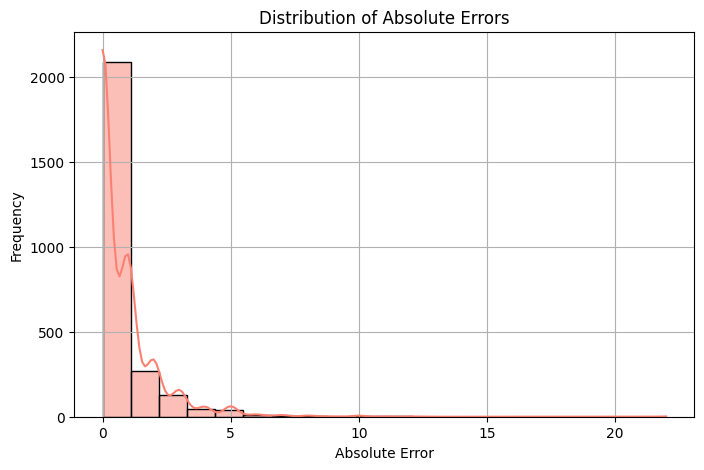

In [36]:
# Visualisasi: Error Distribution
errors = np.abs(np.array(true_ratings) - np.array(predictions))
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True, color='salmon')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Insight: <br>
Berdasarkan visualisasi distribusi Absolute Errors, mayoritas kesalahan prediksi berada di sekitar nilai 0 hingga 2, dengan frekuensi tertinggi pada nilai mendekati 0. Ini menunjukkan bahwa model collaborative filtering umumnya memberikan prediksi rating yang cukup akurat terhadap nilai aslinya. Namun, masih terdapat sebagian kecil error yang lebih besar (hingga lebih dari 20), yang menjadi indikasi adanya outlier atau kasus prediksi yang kurang tepat

In [37]:
# Judul buku yang ingin direkomendasikan
title = 'Clara Callan'
n_recommendations = 10

print(f"Showing recommendations for book: {title}")
print("=" * 40)

# Content-Based Filtering
print("Books with similar content (TF-IDF)")
print("-" * 40)
if title not in sampled_books['Title'].values:
    print("❌ Book title not found in TF-IDF dataset.")
else:
    content_recs = get_recommendations(title, n_recommendations)
    for book_title in content_recs:
        print(book_title)
print("-" * 40)

# Collaborative Filtering (KNN)
print("Top book recommendations from similar users (KNN)")
print("-" * 40)
if title not in book_enc.classes_:
    print("❌ Book title not found in KNN dataset.")
else:
    knn_recs = get_book_recommendations(title, n_recommendations)
    for book_title in knn_recs:
        print(book_title)
print("=" * 40)

Showing recommendations for book: Clara Callan
Books with similar content (TF-IDF)
----------------------------------------
Wildblossom
Going Native
Der Gesang des Troubadours.
The Dollhouse Murders
Globalhead
What Am I Doing Here
Distraction: A Novel
The Real Mother Goose
The SEARCH FOR SNOUT: BRUCE COVILLE'S ALIEN ADVENTURES : THE SEARCH FOR SNOUT: BRUCE COVILLE'S ALIEN ADVENTURES
One
----------------------------------------
Top book recommendations from similar users (KNN)
----------------------------------------


<ipython-input-31-967e89a19ea4>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx = sampled_books[book['Title'] == title].index[0]


Women Talking Dirty
Spanish Lessons : Beginning a New Life in Spain
Algebra and Trigonometry, Unit Circle (6th Edition)
The Dinosaur Project: The Story of the Greatest Dinosaur Hunt Ever Mounted
The Best of Creative Computing
The Biosphere.
Fireworks 2 for Windows and Macintosh Visual Quickstart Guide
Elementary Statistics
Elementary Linear Algebra
The Fractal Geometry of Nature
